<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch05/05_karaage_ai_book_pose_estimation_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIを使った姿勢推定技術

2023/05/16

Google Colabの仕様変更に伴い、ソフトウェアを大幅変更しました。

## 準備

In [1]:
!git clone https://github.com/karaage0703/edge-pose-estimation

Cloning into 'edge-pose-estimation'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 12), reused 14 (delta 4), pack-reused 0
Unpacking objects: 100% (29/29), 5.30 MiB | 6.35 MiB/s, done.


必要なライブラリをセットアップ

In [3]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.0 MB/s eta 0:00:00


必要なライブラリをインポート

In [24]:
import copy
import cv2 as cv
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt

姿勢推定する画像を読み込んで確認します。

In [5]:
!wget https://raw.githubusercontent.com/karaage0703/tf-pose-estimation/master/images/p1.jpg

--2023-05-15 15:03:28--  https://raw.githubusercontent.com/karaage0703/tf-pose-estimation/master/images/p1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10832 (11K) [image/jpeg]
Saving to: ‘p1.jpg’

p1.jpg              100%[===================>]  10.58K  --.-KB/s    in 0s      

2023-05-15 15:03:28 (117 MB/s) - ‘p1.jpg’ saved [10832/10832]



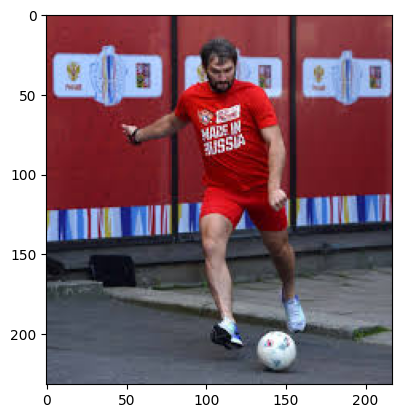

In [8]:
image = cv.imread('./p1.jpg')
plt.imshow(image[:, :, ::-1])

画像から姿勢推定をします。

推論部分の関数を定義します。

In [9]:
def run_inference(onnx_session, input_size, image):
    image_width, image_height = image.shape[1], image.shape[0]

    # Pre process:Resize, BGR->RGB, Reshape, float32 cast
    input_image = cv.resize(image, dsize=(input_size, input_size))
    input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
    input_image = input_image.reshape(-1, input_size, input_size, 3)
    input_image = input_image.astype('float32')

    # Inference
    input_name = onnx_session.get_inputs()[0].name
    output_name = onnx_session.get_outputs()[0].name
    outputs = onnx_session.run([output_name], {input_name: input_image})

    keypoints_with_scores = outputs[0]
    keypoints_with_scores = np.squeeze(keypoints_with_scores)

    # Postprocess:Calc Keypoint
    keypoints = []
    scores = []
    for index in range(17):
        keypoint_x = int(image_width * keypoints_with_scores[index][1])
        keypoint_y = int(image_height * keypoints_with_scores[index][0])
        score = keypoints_with_scores[index][2]

        keypoints.append((keypoint_x, keypoint_y))
        scores.append(score)

    return keypoints, scores

推論した結果を可視化する関数を定義します。

In [23]:
def draw_debug(
    image,
    keypoint_score_th,
    keypoints,
    scores,
):
    debug_image = copy.deepcopy(image)

    connect_list = [
        [0, 1, (255, 0, 0)],  # nose → left eye
        [0, 2, (0, 0, 255)],  # nose → right eye
        [1, 3, (255, 0, 0)],  # left eye → left ear
        [2, 4, (0, 0, 255)],  # right eye → right ear
        [0, 5, (255, 0, 0)],  # nose → left shoulder
        [0, 6, (0, 0, 255)],  # nose → right shoulder
        [5, 6, (0, 255, 0)],  # left shoulder → right shoulder
        [5, 7, (255, 0, 0)],  # left shoulder → left elbow
        [7, 9, (255, 0, 0)],  # left elbow → left wrist
        [6, 8, (0, 0, 255)],  # right shoulder → right elbow
        [8, 10, (0, 0, 255)],  # right elbow → right wrist
        [11, 12, (0, 255, 0)],  # left hip → right hip
        [5, 11, (255, 0, 0)],  # left shoulder → left hip
        [11, 13, (255, 0, 0)],  # left hip → left knee
        [13, 15, (255, 0, 0)],  # left knee → left ankle
        [6, 12, (0, 0, 255)],  # right shoulder → right hip
        [12, 14, (0, 0, 255)],  # right hip → right knee
        [14, 16, (0, 0, 255)],  # right knee → right ankle
    ]

    # Connect Line
    for (index01, index02, color) in connect_list:
        if scores[index01] > keypoint_score_th and scores[
                index02] > keypoint_score_th:
            point01 = keypoints[index01]
            point02 = keypoints[index02]
            cv.line(debug_image, point01, point02, color, 2)

    # Keypoint circle
    for keypoint, score in zip(keypoints, scores):
        if score > keypoint_score_th:
            cv.circle(debug_image, keypoint, 3, (0, 255, 0), -1)

    return debug_image

モデルの読み込みとパラメータの設定をします。

In [25]:
onnx_session = onnxruntime.InferenceSession('./edge-pose-estimation/model/model_float32.onnx')
input_size=192
keypoint_score_th=0.3

推論、可視化を実施します。

In [26]:
# Inference execution
keypoints, scores = run_inference(
    onnx_session,
    input_size,
    image,
)

# Draw
debug_image = draw_debug(
    image,
    keypoint_score_th,
    keypoints,
    scores,
)

姿勢推定結果を表示します。

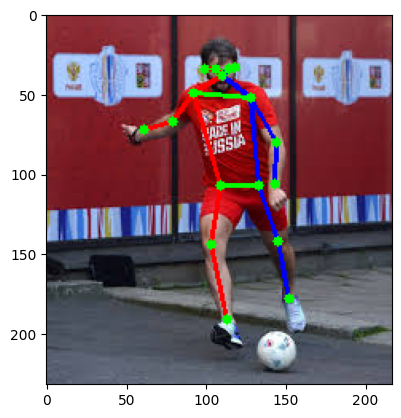

In [27]:
plt.imshow(debug_image[:, :, ::-1])

姿勢推定結果を表示します。

## カメラ

Webカメラを使うJavascriptのコードをダウンロードします。

In [29]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/colab_camera.py

--2023-05-15 15:18:59--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/colab_camera.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3036 (3.0K) [text/plain]
Saving to: ‘colab_camera.py’

colab_camera.py     100%[===================>]   2.96K  --.-KB/s    in 0s      

2023-05-15 15:18:59 (42.2 MB/s) - ‘colab_camera.py’ saved [3036/3036]



コードを読み込みます。

In [30]:
import colab_camera

画像処理のコードを書きます

In [31]:
import IPython
from google.colab import output
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import base64

def run(img_str):
  # decode to image
  decimg = base64.b64decode(img_str.split(',')[1], validate=True)
  decimg = Image.open(BytesIO(decimg))
  decimg = np.array(decimg, dtype=np.uint8); 
  decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

  # pose estimation
  keypoints, scores = run_inference(
    onnx_session,
    input_size,
    decimg,
  )

  out_img = draw_debug(
    decimg,
    keypoint_score_th,
    keypoints,
    scores,
  )

  # encode to string
  _, encimg = cv2.imencode(".jpg", out_img,
      [int(cv2.IMWRITE_JPEG_QUALITY), 80])
  img_str = encimg.tobytes()
  img_str = ("data:image/jpeg;base64," +
      base64.b64encode(img_str).decode('utf-8'))
  return IPython.display.JSON({'img_str': img_str})

output.register_callback('notebook.run', run)

In [ ]:
colab_camera.use_cam()

### アニメ化

顔を上書きする関数を定義します。

In [33]:
def face_overlay(image, image_tmp, cascade):
    # image padding
    padding_size = int(image.shape[1] / 2)
    padding_img = cv2.copyMakeBorder(image, padding_size, padding_size , padding_size, padding_size, cv2.BORDER_CONSTANT, value=(0,0,0))
    image_tmp = cv2.copyMakeBorder(image_tmp, padding_size, padding_size , padding_size, padding_size, cv2.BORDER_CONSTANT, value=(0,0,0))
    image_tmp = image_tmp.astype('float64')

    # face detect
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    facerect = cascade.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=1, minSize=(1, 1))

    # face overlay
    if len(facerect) > 0:
        for rect in facerect:
            face_size = rect[2] * 2
            face_pos_adjust = int(rect[2] * 0.5)
            face_img = cv2.imread('./karaage_icon.png', cv2.IMREAD_UNCHANGED)
            face_img = cv2.resize(face_img, (face_size, face_size))
            mask = face_img[:,:,3]
            mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
            mask = mask / 255.0
            face_img = face_img[:,:,:3]

            image_tmp[rect[1]+padding_size-face_pos_adjust:rect[1]+face_size+padding_size-face_pos_adjust,
                      rect[0]+padding_size-face_pos_adjust:rect[0]+face_size+padding_size-face_pos_adjust] *= 1 - mask
            image_tmp[rect[1]+padding_size-face_pos_adjust:rect[1]+face_size+padding_size-face_pos_adjust,
                      rect[0]+padding_size-face_pos_adjust:rect[0]+face_size+padding_size-face_pos_adjust] += face_img * mask

    image_tmp = image_tmp[padding_size:padding_size+image.shape[0], padding_size:padding_size+image.shape[1]]
    image_tmp = image_tmp.astype('uint8')

    return image_tmp

顔に上書きするアイコンをダウンロードします。

In [34]:
!wget https://raw.githubusercontent.com/karaage0703/karaage_icon/master/karaage_icon.png

--2023-05-15 15:25:36--  https://raw.githubusercontent.com/karaage0703/karaage_icon/master/karaage_icon.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78311 (76K) [image/png]
Saving to: ‘karaage_icon.png’

karaage_icon.png    100%[===================>]  76.48K  --.-KB/s    in 0.01s   

2023-05-15 15:25:36 (5.88 MB/s) - ‘karaage_icon.png’ saved [78311/78311]



顔検出するための、ハールライク特徴量のデータファイルをダウンロードします。

In [35]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml

--2023-05-15 15:25:40--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676709 (661K) [text/plain]
Saving to: ‘haarcascade_frontalface_alt.xml’

haarcascade_frontal 100%[===================>] 660.85K  --.-KB/s    in 0.04s   

2023-05-15 15:25:40 (14.9 MB/s) - ‘haarcascade_frontalface_alt.xml’ saved [676709/676709]



cascadeモデルとしてハールライク特徴量を読み込みます

In [36]:
cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')

アニメ化する関数を定義します。

In [37]:
def run(img_str):
  # decode to image
  decimg = base64.b64decode(img_str.split(',')[1], validate=True)
  decimg = Image.open(BytesIO(decimg))
  decimg = np.array(decimg, dtype=np.uint8); 
  decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

  # pose estimation
  image_org = decimg.copy()

  keypoints, scores = run_inference(
    onnx_session,
    input_size,
    decimg,
  )

  image_tmp = draw_debug(
    decimg,
    keypoint_score_th,
    keypoints,
    scores,
  )

  out_img = face_overlay(image_org, image_tmp, cascade)

  # encode to string
  _, encimg = cv2.imencode(".jpg", out_img,
      [int(cv2.IMWRITE_JPEG_QUALITY), 80])
  img_str = encimg.tobytes()
  img_str = ("data:image/jpeg;base64," +
      base64.b64encode(img_str).decode('utf-8'))
  return IPython.display.JSON({'img_str': img_str})

output.register_callback('notebook.run', run)

In [ ]:
colab_camera.use_cam()